In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron
from scipy.sparse.linalg import expm
large = 40; med = 20; small = 10
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update(params)

# Energy cost function

## [WORKING] Unitary ansatz with depolarizing noise

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse import csc_matrix, kron, eye, identity
# from scipy.sparse.linalg import expm

# class UnitaryVQE:
#     """
#     Finds the maximum value of a cost function using gradient ascent.
#     The Hamiltonian is H(x) = x*X - Delta*Z, and the cost is Tr(H*rho).
#     """

#     # --- Pauli Matrices (Class Attributes) ---
#     I2 = csc_matrix(np.eye(2, dtype=complex))
#     X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
#     Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
#     Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

#     def __init__(self, Delta=0.5, gamma_depol=0.0):
#         """
#         Initializes the optimizer with system and noise parameters.
#         """
#         self.Delta = Delta
#         self.gamma_depol = gamma_depol
        
#         # Pre-calculate the depolarizing noise superoperator.
#         self.D_mat = self._get_depolarizing_superop()
#         self.D_mat_sparse = csc_matrix(self.D_mat) # Store a sparse version for multiplication

#         # --- Storage for results ---
#         self.cost_history = []
#         self.gradients_history = []
#         self.rho_history = []
#         self.x_history = []
#         self.y_history = []
#         self.z_history = []
#         self.best_angles = None
#         # For maximization, the initial best cost is negative infinity.
#         self.best_cost = -np.inf

#     # --- Utility Methods for Liouvillian Formalism ---
#     @staticmethod
#     def _vectorize(rho):
#         """Converts a 2x2 density matrix to a 4x1 column vector."""
#         if hasattr(rho, "toarray"):
#             rho = rho.toarray()
#         return csc_matrix(rho.flatten(order="F")[:, None])

#     @staticmethod
#     def _unvectorize(rho_vec):
#         """Converts a 4x1 density vector back to a 2x2 matrix."""
#         rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
#         return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

#     def _get_bloch_vector(self, rho_mat):
#         """Extracts the Bloch vector components (x, y, z) from a density matrix."""
#         x = np.real(np.trace((self.X @ rho_mat).toarray()))
#         y = np.real(np.trace((self.Y @ rho_mat).toarray()))
#         z = np.real(np.trace((self.Z @ rho_mat).toarray()))
#         return x, y, z

#     # --- Liouvillian Superoperators for Ansatz and Noise ---
#     def _L_depol_super(self):
#         """Generator superoperator for depolarizing noise."""
#         term_x = kron(self.X.conj(), self.X, format='csc')
#         term_y = kron(self.Y.conj(), self.Y, format='csc')
#         term_z = kron(self.Z.conj(), self.Z, format='csc')
#         term_I = kron(self.I2, self.I2, format='csc')
#         return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

#     def _get_depolarizing_superop(self):
#         """Calculates the exponential of the depolarizing superoperator."""
#         if abs(self.gamma_depol) < 1e-12:
#             return identity(4, dtype=complex, format='csc')
#         return expm(self._L_depol_super())

#     def _L_int_ansatz(self, x_mean):
#         """Liouvillian for the ansatz interaction term: L_int = -i[x*X, .]"""
#         H_int = x_mean * self.X
#         return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))
    
#     def _L_f_ansatz(self):
#         """Liouvillian for the ansatz field term: L_f = -i[-Delta*Z, .]"""
#         H_f = -self.Delta * self.Z
#         return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

#     # --- Cost Function and Gradients ---
#     def _get_hamiltonian(self, x_val):
#         """Constructs the total physical Hamiltonian H = x*X - Delta*Z."""
#         return x_val * self.X - self.Delta * self.Z

#     def _cost_function(self, rho_final_mat, x_final):
#         """Cost function C = Tr(H(x_final) * rho_final)."""
#         H_final = self._get_hamiltonian(x_final)
#         return np.real(np.trace((H_final @ rho_final_mat).toarray()))
    
#     # def _cost_function(self, rho_final_mat, x_final):
#     #     H_final = self._get_hamiltonian(x_final)
#     #     base_cost = np.real(np.trace((H_final @ rho_final_mat).toarray()))
#     #     _, _, z = self._get_bloch_vector(rho_final_mat)
#     #     penalty = 100 * max(0, z)  # Penalize positive z
#     #     return base_cost - penalty    

#     def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history, bloch_history):
#         """Calculates the gradients of the cost function C = Tr(H*rho)."""
#         E_int_list, E_f_list = evolvers
#         grads = [[0.0] * 2 for _ in range(n_layers)]

#         rho_final_vec = rho_history[-1]
#         rho_final_mat = self._unvectorize(rho_final_vec)
#         x_final = x_history[-1]
#         H_final = self._get_hamiltonian(x_final)

#         for l in range(n_layers):
#             propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
#             for i in range(l + 1, n_layers):
#                 propagator_after_layer = propagators[i] @ propagator_after_layer
            
#             rho_before_layer = rho_history[l]

#             def compute_gradient_from_drho(d_rho_final_vec):
#                 """Computes dC/dθ using the full chain rule."""
#                 d_rho_final_mat = self._unvectorize(d_rho_final_vec)
#                 dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
#                 term1 = x_final * dx_dtheta
#                 term2 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
#                 return term1 + term2

#             # --- Gradient for theta_int (using custom formula) ---
#             y_before_gate = bloch_history[l][1]
#             z_before_gate = bloch_history[l][2]
#             x_for_hamiltonian = x_history[l]
#             d_rho_at_gate_mat = x_for_hamiltonian * (y_before_gate * self.Z - z_before_gate * self.Y)
#             d_rho_at_gate_vec = self._vectorize(d_rho_at_gate_mat)
#             propagate_superop = propagator_after_layer @ self.D_mat_sparse @ E_f_list[l] @ self.D_mat_sparse
#             d_rho_final_vec_int = propagate_superop @ d_rho_at_gate_vec
#             grads[l][0] = compute_gradient_from_drho(d_rho_final_vec_int)

#             # --- Gradient for theta_f (original calculation) ---
#             A_f = self.D_mat_sparse
#             B_f = E_f_list[l] @ self.D_mat_sparse @ E_int_list[l] @ self.D_mat_sparse
#             L_f = self._L_f_ansatz()
#             dM_dtheta_f = A_f @ L_f @ B_f
#             d_rho_in_layer_f = dM_dtheta_f @ rho_before_layer
#             d_rho_final_vec_f = propagator_after_layer @ d_rho_in_layer_f
#             grads[l][1] = compute_gradient_from_drho(d_rho_final_vec_f)
            
#         return grads

#     # --- VQA Core Logic ---
#     def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):
#         """Applies the ansatz D*U*D for all layers."""
#         rho_vec = rho_initial_vec.copy()
        
#         rho_history = [rho_vec]
#         x_history = []
#         bloch_history = []
#         evolvers = ([], []) 
#         propagators = []

#         for i in range(n_layers):
#             theta_int, theta_f = angles_list[i]
            
#             rho_current_mat = self._unvectorize(rho_vec)
#             x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
#             x_history.append(x_current)
#             bloch_history.append((x_current, y_current, z_current))

#             E_int = expm(theta_int * self._L_int_ansatz(x_current))
#             E_f   = expm(theta_f   * self._L_f_ansatz())
            
#             M = self.D_mat_sparse @ E_f @ self.D_mat_sparse @ E_int @ self.D_mat_sparse
#             rho_vec = M @ rho_vec
            
#             rho_history.append(rho_vec)
#             evolvers[0].append(E_int)
#             evolvers[1].append(E_f)
#             propagators.append(M)

#         x_final, _, _ = self._get_bloch_vector(self._unvectorize(rho_vec))
#         x_history.append(x_final)

#         return rho_vec, evolvers, propagators, rho_history, x_history, bloch_history

#     def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
#         """Runs the main VQA gradient ascent loop."""
#         perturbation = 0*1.e-1
#         rx = np.sqrt(1 - self.Delta**2) + perturbation
#         ry = 0.0 + perturbation
#         rz = - self.Delta + perturbation

#         # rx = 0.1
#         # rz = - 0.9
#         # ry = np.sqrt(1 - rx**2 - rz**2)  # Ensure the Bloch vector is normalized

#         print('rx, ry, rz:', rx, ry, rz)

#         rho_initial_mat = (self.I2.toarray() + rx * self.X.toarray() + ry * self.Y.toarray() + rz * self.Z.toarray()) / 2
#         rho_initial_mat = rho_initial_mat / np.trace(rho_initial_mat)
#         rho_initial_vec = self._vectorize(rho_initial_mat)
        
#         angles = [list(params) for params in initial_angles]
#         self.best_angles = [list(a) for a in angles]
#         self.best_cost = -np.inf # Start at lowest possible value for maximization

#         print("\n--- Starting VQE (Gradient Ascent for Maximization) ---")
        
#         self.cost_history.clear()
#         self.gradients_history.clear()
#         self.x_history.clear()
#         self.y_history.clear()
#         self.z_history.clear()

#         for iteration in range(max_iterations):
#             rho_final_vec, evolvers, propagators, rho_hist, x_hist, bloch_hist = \
#                 self._variational_ansatz(n_layers, angles, rho_initial_vec)

#             rho_final_mat = self._unvectorize(rho_final_vec)
#             self.rho_history.append(rho_final_mat)
#             x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
#             current_cost = self._cost_function(rho_final_mat, x_final)

#             self.cost_history.append(current_cost)
#             self.x_history.append(x_final)
#             self.y_history.append(y_final)
#             self.z_history.append(z_final)
            
#             # For maximization, we look for a larger cost
#             if current_cost > self.best_cost:
#                 self.best_cost = current_cost
#                 self.best_angles = [list(a) for a in angles]
            
#             print(f"Iter {iteration:03d}: Cost = {current_cost:+.6f}")

#             if iteration > 1 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
#                 print(f"\nConvergence criterion met at iteration {iteration}!")
#                 break
            
#             gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist, bloch_hist)
#             self.gradients_history.append(gradients)
            
#             grad_norm = np.linalg.norm(np.array(gradients))
#             if grad_norm > clip_threshold:
#                 gradients = (np.array(gradients) * (clip_threshold / grad_norm)).tolist()
            
#             # THE KEY CHANGE: Use '+' for gradient ASCENT
#             for l in range(n_layers):
#                 for k in range(2):
#                     angles[l][k] += learning_rate * gradients[l][k]
                    
#         print("\n--- Optimization Finished ---")
#         return self.best_angles, self.best_cost, self.cost_history, self.rho_history

#     def plot_results(self):
#         """Plots the cost history and Bloch vector evolution."""
#         if not self.cost_history:
#             print("No history to plot. Please run the VQA first.")
#             return

#         fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
#         fig.suptitle("Unitary VQE (Maximization using Gradient Ascent)", fontsize=16)

#         # Plot 1: Cost Function
#         ax1.plot(self.cost_history, 'o-', color='crimson', markersize=5, label='Cost')
#         e_max = np.sqrt(np.array(self.x_history)**2 + self.Delta**2)
#         ax1.plot(e_max, color='red', linestyle='--', label=r'$E_{\mathrm{max}}=\sqrt{x^{2}+\Delta^{2}}$')
#         ax1.set_xlabel("Iterations")
#         ax1.set_ylabel("Cost")
#         ax1.legend()
#         # ax1.grid(True, linestyle='--', alpha=0.6)
#         ax1.set_title("Cost Function Evolution (Maximization)")

#         # Plot 2: Bloch Vector Components
#         iterations = range(len(self.x_history))
#         ax2.plot(iterations, self.x_history, 'o-', color='darkorange', markersize=5, label='<X>')
#         ax2.plot(iterations, self.y_history, 's-', color='forestgreen', markersize=5, label='<Y>')
#         ax2.plot(iterations, self.z_history, '^-', color='firebrick', markersize=5, label='<Z>')
#         ax2.axhline(self.Delta, color='darkorange', linestyle='--', label=r'$\Delta$')
#         ax2.axhline(- self.Delta, color='darkorange', linestyle='--', label=r'$-\Delta$')        
#         ax2.axhline( - np.sqrt(1 - self.Delta**2), color='forestgreen', linestyle=':', label=r'-$\sqrt{1 - \Delta^{2}}$')
#         ax2.axhline(np.sqrt(1 - self.Delta**2), color='forestgreen', linestyle=':', label=r'$\sqrt{1 - \Delta^{2}}$')
#         ax2.axhline(0, color='black', linestyle='--')
        
#         ax2.set_xlabel("Iterations")
#         ax2.set_ylabel("Bloch Vector Components")
#         ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#         # ax2.grid(True, linestyle='--', alpha=0.6)
#         ax2.set_title("Evolution of Bloch Vector")

#         # Plot 3: Gradients
#         if self.gradients_history:
#             last_layer_grads_history = np.array([g[-1] for g in self.gradients_history])
#             grads_by_param = last_layer_grads_history.T
#             param_names = ['int', 'f']
#             colors = plt.cm.viridis(np.linspace(0, 1, 2))
#             for i, grad_line in enumerate(grads_by_param):
#                 ax3.plot(range(len(grad_line)), grad_line, lw=1.5, color=colors[i], 
#                          label=f'$\\nabla C(\\theta_{{{param_names[i]}}})$')
        
#         ax3.set_xlabel("Iterations")
#         ax3.set_ylabel("Gradient Value")
#         # ax3.grid(True, linestyle='--', alpha=0.6)
#         ax3.set_title("Last Layer Gradient Evolution")
#         ax3.legend(loc='upper right')
        
#         plt.tight_layout(rect=[0, 0, 1, 0.96])
#         plt.show()

# # --- Main execution block ---
# if __name__ == '__main__':
#     vqe = UnitaryVQE(Delta=0.6, gamma_depol=0.005)
    
#     n_layers = 2
#     # np.random.seed(1729)
#     # initial_angles = [[np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5)] for _ in range(n_layers)]
#     initial_angles = [[1.5, 1.5 * vqe.Delta] for _ in range(n_layers)]  # Fixed initial angles for reproducibility
#     print(f"Initial angles: {initial_angles}")

#     best_angles, best_cost, cost_history, rho_history = vqe.run_vqa(
#         n_layers=n_layers,
#         initial_angles=initial_angles,
#         learning_rate=0.1,
#         max_iterations=300,
#         tolerance=1e-7,
#         clip_threshold=1.0
#     )

#     vqe.plot_results()

## Non-unitary ansatz with depolarizing noise

### Ansatz layer order changed from original

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, kron, eye, identity
from scipy.sparse.linalg import expm

class NonUnitaryVQE:
    """
    Finds the maximum energy state of a self-consistent mean-field Hamiltonian
    H(x) = x*X - Delta*Z using gradient ascent. The ansatz can include
    non-unitary dissipative gates and depolarizing noise.
    """

    # --- Pauli Matrices (Class Attributes) ---
    I2 = csc_matrix(np.eye(2, dtype=complex))
    X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
    Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
    Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

    def __init__(self, Delta, gamma_depol, dissipative = False):
        """
        Initializes the optimizer with system and noise parameters.
        """
        self.Delta = Delta
        self.gamma_depol = gamma_depol
        self.n_params = 4 if self.is_dissipative else 2
        
        # If there are no dissipation then the Lindblad operators are zero matrices
        self.is_dissipative = dissipative
        self.L1_op = csc_matrix((self.X - 1j * self.Y) / 2) if dissipative else csc_matrix((2,2), dtype=complex)
        self.L2_op = csc_matrix((self.I2.toarray() + self.Z.toarray()) / 2) if dissipative else csc_matrix((2,2), dtype=complex)

        # Depolarizing noise channel
        self.D_mat = self._get_depolarizing_superop()
        self.D_mat_sparse = csc_matrix(self.D_mat)

        # Storage for results
        self.cost_history = []
        self.gradients_history = []
        self.rho_history = []
        self.x_history = []
        self.y_history = []
        self.z_history = []
        self.best_angles = None
        self.best_cost = -np.inf

    @staticmethod
    def _vectorize(rho):
        if hasattr(rho, "toarray"):
            rho = rho.toarray()
        return csc_matrix(rho.flatten(order="F")[:, None])

    @staticmethod
    def _unvectorize(rho_vec):
        rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
        return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

    def _get_bloch_vector(self, rho_mat):
        x = np.real(np.trace((self.X @ rho_mat).toarray()))
        y = np.real(np.trace((self.Y @ rho_mat).toarray()))
        z = np.real(np.trace((self.Z @ rho_mat).toarray()))
        return x, y, z

    def _L_depol_super(self):
        term_x = kron(self.X.conj(), self.X, format='csc')
        term_y = kron(self.Y.conj(), self.Y, format='csc')
        term_z = kron(self.Z.conj(), self.Z, format='csc')
        term_I = kron(self.I2, self.I2, format='csc')
        return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

    def _get_depolarizing_superop(self):
        if abs(self.gamma_depol) < 1e-12:
            return identity(4, dtype=complex, format='csc')
        return expm(self._L_depol_super())

    def _L_int_ansatz(self, x_mean):
        H_int = x_mean * self.X
        return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))
    
    def _L_f_ansatz(self):
        H_f = -self.Delta * self.Z
        return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

    def _L_exc_ansatz(self):
        L_op = self.L1_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _L_dep_ansatz(self):
        L_op = self.L2_op
        LdL = L_op.conj().T @ L_op
        return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

    def _get_hamiltonian(self, x_val):
        return x_val * self.X - self.Delta * self.Z

    def _cost_function(self, rho_final_mat, x_final):
        H_final = self._get_hamiltonian(x_final)
        return np.real(np.trace((H_final @ rho_final_mat).toarray()))

    # --- MODIFICATION: Gradients updated for new ansatz order ---
    def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history, bloch_history):
        grads = [[0.0] * self.n_params for _ in range(n_layers)]
        rho_final_vec = rho_history[-1]
        rho_final_mat = self._unvectorize(rho_final_vec)
        x_final = x_history[-1]
        H_final = self._get_hamiltonian(x_final)

        for l in range(n_layers):
            propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
            for i in range(l + 1, n_layers):
                propagator_after_layer = propagators[i] @ propagator_after_layer
            
            rho_before_layer = rho_history[l]

            def compute_gradient_from_drho(d_rho_final_vec):
                d_rho_final_mat = self._unvectorize(d_rho_final_vec)
                dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
                term1 = x_final * dx_dtheta
                term2 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
                return term1 + term2
            
            D = self.D_mat_sparse

            if not self.is_dissipative:
                E_int, E_f = evolvers[0][l], evolvers[1][l]
                y_before_gate = bloch_history[l][1]
                z_before_gate = bloch_history[l][2]
                x_for_hamiltonian = x_history[l]
                d_rho_at_gate_mat = x_for_hamiltonian * (y_before_gate * self.Z - z_before_gate * self.Y)
                d_rho_at_gate_vec = self._vectorize(d_rho_at_gate_mat)
                propagate_superop = propagator_after_layer @ D @ E_f @ D
                d_rho_final_vec_int = propagate_superop @ d_rho_at_gate_vec
                grads[l][0] = compute_gradient_from_drho(d_rho_final_vec_int)
                A_f = D
                B_f = E_f @ D @ E_int @ D
                L_f = self._L_f_ansatz()
                dM_dtheta_f = A_f @ L_f @ B_f
                d_rho_in_layer_f = dM_dtheta_f @ rho_before_layer
                d_rho_final_vec_f = propagator_after_layer @ d_rho_in_layer_f
                grads[l][1] = compute_gradient_from_drho(d_rho_final_vec_f)
            else:
                E_int, E_f, E_exc, E_dep = evolvers[0][l], evolvers[1][l], evolvers[2][l], evolvers[3][l]
                
                # --- Gradient for theta_int (first gate) ---
                rho_pre_int = D @ rho_before_layer
                x_pre_int, y_pre_int, z_pre_int = self._get_bloch_vector(self._unvectorize(rho_pre_int))
                deriv_mat_local = x_pre_int * (y_pre_int * self.Z - z_pre_int * self.Y)
                deriv_vec_local = self._vectorize(deriv_mat_local)
                prop_from_int = D @ E_dep @ D @ E_f @ D @ E_exc @ D
                d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
                grads[l][0] = compute_gradient_from_drho(d_rho_final)
                
                # --- Gradient for theta_exc (second gate) ---
                rho_post_exc = E_exc @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_exc_ansatz() @ rho_post_exc
                prop_from_exc = D @ E_dep @ D @ E_f @ D
                d_rho_final = propagator_after_layer @ prop_from_exc @ deriv_vec_local
                grads[l][2] = compute_gradient_from_drho(d_rho_final)

                # --- Gradient for theta_f (third gate) ---
                rho_post_f = E_f @ D @ E_exc @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_f_ansatz() @ rho_post_f
                prop_from_f = D @ E_dep @ D
                d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
                grads[l][1] = compute_gradient_from_drho(d_rho_final)
                
                # --- Gradient for theta_dep (fourth gate) ---
                rho_post_dep = E_dep @ D @ E_f @ D @ E_exc @ D @ E_int @ D @ rho_before_layer
                deriv_vec_local = self._L_dep_ansatz() @ rho_post_dep
                prop_from_dep = D
                d_rho_final = propagator_after_layer @ prop_from_dep @ deriv_vec_local
                grads[l][3] = compute_gradient_from_drho(d_rho_final)

        return grads

    def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):
        rho_vec = rho_initial_vec.copy()
        rho_history = [rho_vec]
        x_history = []
        bloch_history = []
        evolvers = ([], [], [], []) if self.is_dissipative else ([], [])
        propagators = []
        D = self.D_mat_sparse

        for i in range(n_layers):
            if self.is_dissipative:
                theta_int, theta_f, theta_exc, theta_dep = angles_list[i]
            else:
                theta_int, theta_f = angles_list[i]
                theta_exc, theta_dep = 0.0, 0.0
            
            rho_current_mat = self._unvectorize(rho_vec)
            x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
            x_history.append(x_current)
            bloch_history.append((x_current, y_current, z_current))

            E_int = expm(theta_int * self._L_int_ansatz(x_current))
            E_f   = expm(theta_f   * self._L_f_ansatz())
            
            if self.is_dissipative:
                E_exc = expm(theta_exc * self._L_exc_ansatz())
                E_dep = expm(theta_dep * self._L_dep_ansatz())
                # --- MODIFICATION: Applying the new user-specified gate order ---
                # Order: int -> exc -> f -> dep
                M = D @ E_dep @ D @ E_f @ D @ E_exc @ D @ E_int @ D
            else:
                M = D @ E_f @ D @ E_int @ D

            rho_vec = M @ rho_vec
            
            rho_mat_temp = self._unvectorize(rho_vec)
            trace_val = np.trace(rho_mat_temp.toarray())
            if abs(trace_val) > 1e-12:
                 rho_vec = self._vectorize(rho_mat_temp / trace_val)
            
            rho_history.append(rho_vec)
            evolvers[0].append(E_int)
            evolvers[1].append(E_f)
            if self.is_dissipative:
                evolvers[2].append(E_exc)
                evolvers[3].append(E_dep)
            propagators.append(M)

        x_final, _, _ = self._get_bloch_vector(self._unvectorize(rho_vec))
        x_history.append(x_final)

        return rho_vec, evolvers, propagators, rho_history, x_history, bloch_history

    def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
        expected_params = self.n_params
        for i, layer_angles in enumerate(initial_angles):
            if len(layer_angles) != expected_params:
                raise ValueError(f"Layer {i}: Expected {expected_params} parameters, got {len(layer_angles)}")
                
        perturbation = 7.0 *1.e-1
        rx = np.sqrt(1 - self.Delta**2) - perturbation
        rz = - self.Delta + perturbation
        if np.abs(1 - rx**2 - rz**2) < 1.e-10:
            ry = 0
        else:
            ry = np.sqrt(1 - rx**2 - rz**2)  # Ensure the Bloch vector is normalized

        rho_initial_mat = (self.I2.toarray() + rx*self.X.toarray() + ry*self.Y.toarray() + rz*self.Z.toarray())/2
        rho_initial_mat /= np.trace(rho_initial_mat)
        rho_initial_vec = self._vectorize(rho_initial_mat)
        
        angles = [list(params) for params in initial_angles]
        self.best_angles = [list(a) for a in angles]
        self.best_cost = -np.inf

        print("\n--- Starting VQE (Gradient Ascent for Maximization) ---")
        print(f"Using {'dissipative' if self.is_dissipative else 'unitary'} ansatz ({self.n_params} params/layer)")
        
        self.cost_history.clear()
        self.gradients_history.clear()
        self.rho_history = []
        self.x_history.clear()
        self.y_history.clear()
        self.z_history.clear()

        for iteration in range(max_iterations):
            rho_final_vec, evolvers, propagators, rho_hist, x_hist, bloch_hist = \
                self._variational_ansatz(n_layers, angles, rho_initial_vec)

            rho_final_mat = self._unvectorize(rho_final_vec)
            self.rho_history.append(rho_final_mat)
            x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
            current_cost = self._cost_function(rho_final_mat, x_final)

            self.cost_history.append(current_cost)
            self.x_history.append(x_final)
            self.y_history.append(y_final)
            self.z_history.append(z_final)
            
            if current_cost > self.best_cost:
                self.best_cost = current_cost
                self.best_angles = [list(a) for a in angles]
            
            print(f"Iter {iteration:03d}: Cost = {current_cost:+.6f}")

            if iteration > 1 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
                print(f"\nConvergence criterion met at iteration {iteration}!")
                break
            
            gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist, bloch_hist)
            self.gradients_history.append(gradients)
            
            grad_norm = np.linalg.norm(np.array(gradients))
            if grad_norm > clip_threshold:
                gradients = (np.array(gradients) * (clip_threshold / grad_norm)).tolist()
            
            for l in range(n_layers):
                for k in range(self.n_params):
                    angles[l][k] += learning_rate * gradients[l][k]
            # Print the gradients for debugging
            # grads_by_param = np.array([g[0] for g in self.gradients_history])
            print(f"Gradients at iteration {iteration}: {gradients}")
                    
        print("\n--- Optimization Finished ---")
        return self.best_angles, self.best_cost, self.cost_history, self.rho_history, self.gradients_history

    def plot_results(self):
        if not self.cost_history:
            print("No history to plot. Please run the VQA first.")
            return

        # Plot 1: Cost
        fig_cost, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        fig_cost.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)
        ax1.plot(self.cost_history, 'o-', color='crimson', markersize=3, label='Cost')
        e_max = np.sqrt(np.array(self.x_history)**2 + self.Delta**2)
        ax1.plot(e_max, color='red', linestyle='--', label=r'$E_{\mathrm{max}}=\sqrt{x^{2}+\Delta^{2}}$')
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Cost")
        ax1.legend()
        # ax1.set_ylim(0, 1.5)
        ax1.set_title("Cost Function Evolution (Maximization)")
        plt.tight_layout()
        plt.show()

        # Plot 2: Bloch Vector
        fig_bloch, ax2 = plt.subplots(1, 1, figsize=(10, 5))
        fig_bloch.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)
        iterations = range(len(self.x_history))
        ax2.plot(iterations, self.x_history, 'o-', color='darkorange', markersize=3, label='<X>')
        ax2.plot(iterations, self.y_history, 's-', color='forestgreen', markersize=3, label='<Y>')
        ax2.plot(iterations, self.z_history, '^-', color='firebrick', markersize=3, label='<Z>')
        ax2.axhline(self.Delta, color='red', linestyle='--', label=r'$\Delta$')
        ax2.axhline(-self.Delta, color='red', linestyle='--', label=r'$-\Delta$')
        ax2.axhline(-np.sqrt(1 - self.Delta**2), color='blue', linestyle=':', label=r'-$\sqrt{1 - \Delta^{2}}$')
        ax2.axhline(np.sqrt(1 - self.Delta**2), color='blue', linestyle=':', label=r'$\sqrt{1 - \Delta^{2}}$')
        ax2.axhline(0, color='black', linestyle='--')
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("Bloch Vector Components")
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax2.set_title("Evolution of Bloch Vector")
        plt.tight_layout()
        plt.show()

        # Plot 3: Last Layer Gradient
        fig_grads, ax3 = plt.subplots(1, 1, figsize=(10, 5))
        fig_grads.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)
        if self.gradients_history:
            all_gradients = np.abs(np.array([np.mean(grads, axis=0) for grads in self.gradients_history]))
            grads_by_param = all_gradients.T
            # last_layer_grads_history = np.array([g[-1] for g in self.gradients_history])
            # grads_by_param = last_layer_grads_history.T


            # Print the gradients for debugging
            print("Gradients for last layer:", grads_by_param)
            param_names = ['int', 'f', 'exc', 'dep'][:self.n_params]
            colors = plt.cm.viridis(np.linspace(0, 1, self.n_params))
            for i, grad_line in enumerate(grads_by_param):
                ax3.plot(range(len(grad_line)), grad_line, lw=3.5, color=colors[i],
                         label=f'$\\nabla C(\\theta_{{{param_names[i]}}})$')
        ax3.set_xlabel("Iterations")
        ax3.set_ylabel("Gradient Value")
        ax3.set_yscale('log')
        ax3.legend(loc='upper right')
        ax3.set_title("Last Layer Gradient Evolution")
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    vqe = NonUnitaryVQE(
        Delta=0.3, 
        gamma_depol=0.0
    )
    
    n_layers = 7
    # np.random.seed(1729)
    
    n_params = vqe.n_params
    initial_angles = [
        [0.5 for _ in range(n_params)] 
        for _ in range(n_layers)
    ]
    print(f"Initial angles: {initial_angles}")

    best_angles, best_cost, cost_history, rho_history, gradients_history = vqe.run_vqa(
        n_layers=n_layers,
        initial_angles=initial_angles,
        learning_rate=0.007, # learning rate = {'7:0.007, '8:0.008, '9':0.009}
        max_iterations=290,
        tolerance=1e-7,
        clip_threshold=10.0
    )

    vqe.plot_results()

    exact_cost = np.sqrt(vqe.x_history[-1]**2 + vqe.Delta**2)
    rho_cost = vqe.x_history[-1]**2 - vqe.Delta * vqe.z_history[-1]
    print('Norm of the final Bloch vector:', np.sqrt(vqe.x_history[-1]**2 + vqe.y_history[-1]**2 + vqe.z_history[-1]**2))
    print('Absolute difference between exact cost and rho cost:', abs(exact_cost - rho_cost))

In [ ]:
# import numpy as np

# # Calculate the L2 norm of each angle's gradients at every iteration
# import matplotlib.pyplot as plt

# grad_norms = []
# for iteration_grads in gradients_history:
#      # Convert to an array of shape (n_layers, n_params)
#      iteration_grads_array = np.array(iteration_grads)
#      # Sum over layers (axis=0) to get each angle's total gradient, then take L2 norm
#      angle_norms = np.sqrt((iteration_grads_array**2).sum(axis=0))
#      grad_norms.append(angle_norms)

# grad_norms = np.array(grad_norms)  # shape: (num_iterations, n_params)

# plt.figure(figsize=(10, 7))
# for j in range(grad_norms.shape[1]):
#      plt.plot(grad_norms[:, j], label=f"Angle {j} Norm", linewidth=2.5)
# plt.xlabel("Iteration")
# plt.ylabel("Gradient Norm")
# plt.legend()
# plt.show()

## Barren plateau for different $\epsilon$

In [10]:
# First, run the optimizer and store the results in a dictionary without plotting:
all_grad_norms = {}

noise_levels = [0.0, 0.001, 0.005, 0.01]
learning_rate = 0.007
max_iterations = 290
n_layers = 7

gamma_e = 0.01
gamma_d = 0.01

for gamma_depol in noise_levels:
    print(f"\n--- Running with gamma_depol = {gamma_depol} ---")
    vqe = NonUnitaryVQE(Delta=0.3, gamma_e=gamma_e, gamma_d=gamma_d, gamma_depol=gamma_depol)
    initial_angles = [
        [0.5 for _ in range(vqe.n_params)]
        for _ in range(n_layers)
    ]
    best_angles, best_cost, cost_history, rho_history, gradients_history = vqe.run_vqa(
        n_layers, initial_angles, learning_rate, max_iterations
    )
    iteration_grad_norms = []
    for iteration_grads in gradients_history:
        iteration_grads_array = np.array(iteration_grads)
        mean_grads_all = iteration_grads_array.mean(axis=0)
        grad_norm = np.linalg.norm(mean_grads_all)
        iteration_grad_norms.append(grad_norm)

    all_grad_norms[gamma_depol] = iteration_grad_norms

if gamma_e > 0 or gamma_d > 0:
    np.save('grad_norms_dissipative_'+str(gamma_depol)+ '_' + str(gamma_e) + '_' + str(gamma_d) +'.npy', all_grad_norms)
else:
    np.save('grad_norms_unitary_'+str(gamma_depol)+'.npy', all_grad_norms)


--- Running with gamma_depol = 0.0 ---

--- Starting VQE (Gradient Ascent for Maximization) ---
Using dissipative ansatz (4 params/layer)
Iter 000: Cost = +0.049980
Gradients at iteration 0: [[0.2757227875317317, 0.09466353552356999, -0.007512470544085015, 0.0007062935346159796], [0.4603523544824249, 0.13911028261027786, -0.005672366037818238, 0.0005746870133912393], [0.5038574506598011, 0.19571559317584, -0.0017158264452342522, -0.0005772615824770525], [0.3839708603453359, 0.23248769874728598, 0.001152565777779775, -0.0012407060839876034], [0.14823208643646874, 0.24829341782362524, 0.00193139891024243, -0.0012518104120534653], [-0.04085988680365224, 0.23952120299856278, 0.0017876892650441623, -0.0012880342706140249], [-0.13347575441998516, 0.17172891342039892, 0.0014566675513385256, -0.0013982405576005341]]
Iter 001: Cost = +0.050944
Gradients at iteration 1: [[0.2762693807814861, 0.09542467292238778, -0.007538610970726667, 0.0007034185505899866], [0.4613301301780548, 0.1398861612240

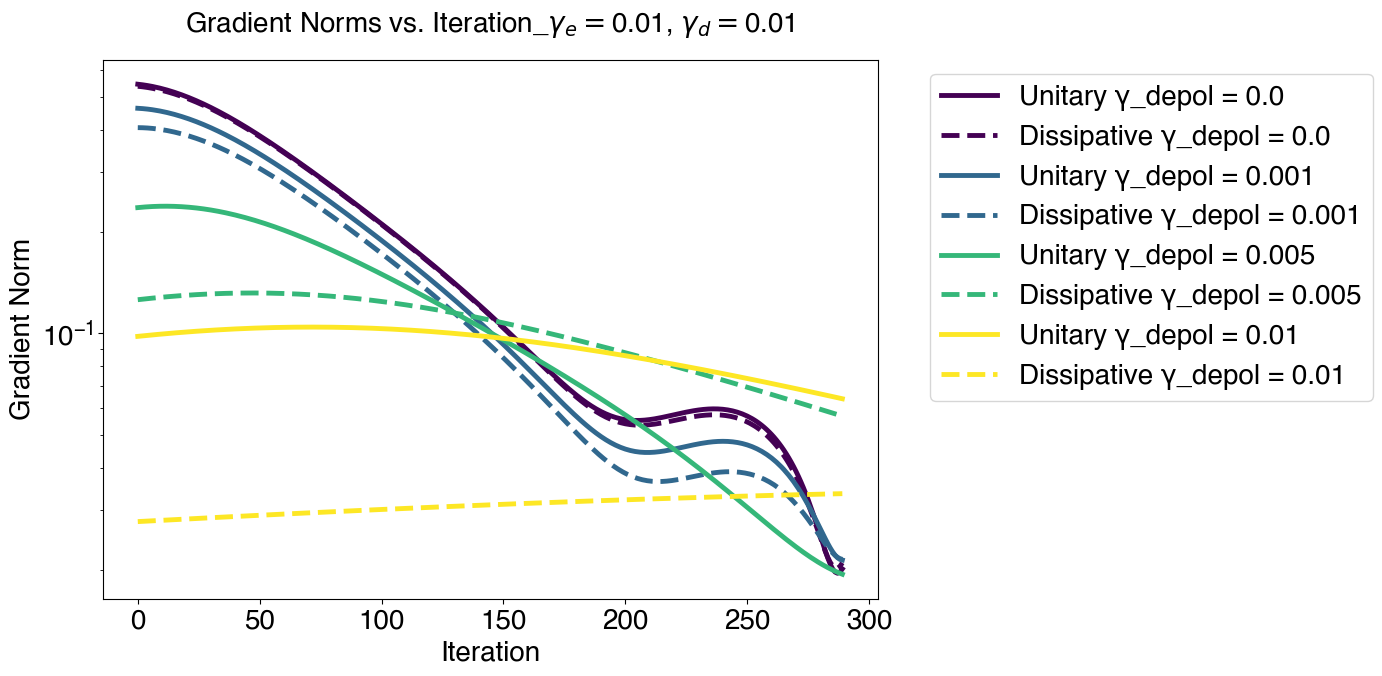

In [12]:
unitary_grad_norms = np.load('grad_norms_unitary_0.01.npy', allow_pickle=True).item()
from matplotlib import colors
dissipative_grad_norms = np.load('grad_norms_dissipative_0.01_0.002_0.002.npy', allow_pickle=True).item()

import matplotlib.pyplot as plt

# Plotting the gradient norms
plt.figure(figsize=(10, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(noise_levels)))
for i, gamma_depol in enumerate(noise_levels):
     if gamma_depol in unitary_grad_norms:
          grad_norms = unitary_grad_norms[gamma_depol]
          plt.plot(grad_norms, linestyle='-', label=f'Unitary γ_depol = {np.around(gamma_depol, 5)}', linewidth=3.5, color=colors[i])
     if gamma_depol in dissipative_grad_norms:
          grad_norms = dissipative_grad_norms[gamma_depol]
          plt.plot(grad_norms,  linestyle='--', label=f'Dissipative γ_depol = {np.around(gamma_depol, 5)}', linewidth=3.5, color=colors[i])

plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.title(r'Gradient Norms vs. Iteration_$\gamma_{e}=$' + str(gamma_e) + r', $\gamma_{d}=$' + str(gamma_d))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('grad_norms_comparison_'+str(gamma_e)+'_'+str(gamma_d)+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Plotting the gradient norms
# plt.figure(figsize=(10, 7))
# for gamma_depol, grad_norms in all_grad_norms.items():
#      plt.plot(grad_norms, label=f'γ_depol = {np.around(gamma_depol, 5)}', linewidth=2.5)

# plt.xlabel('Iteration')
# plt.ylabel('Gradient Norm')
# # plt.yscale('log')
# plt.title('Gradient Norms vs. Iteration for Different Depolarizing Noise Levels')
# plt.legend()
# if gamma_e > 0 or gamma_d > 0:
#      plt.savefig('gradient_norms_vs_iteration_dissipative.png', dpi=600, bbox_inches='tight')  
# else:
#      plt.savefig('gradient_norms_vs_iteration_unitary.png', dpi=600, bbox_inches='tight')        
# plt.show()

## Barren plateau for different layers for a fixed $\epsilon$

In [ ]:
# def analyze_gradients(epsilon, layer_list, gamma_e, gamma_d, max_iterations):
#      """
#      For a given epsilon (gamma_depol), calculates the average gradient of each angle
#      over all layers, for multiple choices of n_layers. Optionally set gamma_e and gamma_d
#      for dissipative gates. Returns a dictionary mapping n_layers -> (iterations x n_params) array.
#      """
#      avg_grads_per_layer = {}

#      # Use different learning rates for different layers
#      learning_rate_dict = {
#           '2': 0.03,
#           '3': 0.025,
#           '4': 0.025,
#           '5': 0.025,
#           '6': 0.03,
#           '7': 0.007
#      }

#      for n_layers in layer_list:
#           learning_rate = learning_rate_dict.get(str(n_layers), 0.01)  # Default to 0.01 if not found
#           # Create the VQE instance
#           vqe_temp = NonUnitaryVQE(Delta=0.3, gamma_e=gamma_e, gamma_d=gamma_d, gamma_depol=epsilon)
#           # Prepare initial angles
#           initial_angles = [[0.5 for _ in range(vqe_temp.n_params)] for _ in range(n_layers)]
#           # Run optimization
#           _, _, _, _, gradients_history_temp = vqe_temp.run_vqa(
#                n_layers=n_layers,
#                initial_angles=initial_angles,
#                learning_rate=learning_rate,
#                max_iterations=max_iterations
#           )
#           # gradients_history_temp is a list of shape (max_iterations, n_layers, n_params)
#           iter_count = len(gradients_history_temp)
#           n_params = vqe_temp.n_params
          
#           # Average gradients across layers for each iteration
#           avg_grads = []
#           for it in range(iter_count):
#                layer_grads = gradients_history_temp[it]  # shape: (n_layers, n_params)
#                mean_over_layers = np.mean(layer_grads, axis=0)  # shape: (n_params,)
#                avg_grads.append(mean_over_layers)
          
#           avg_grads = np.array(avg_grads)  # shape: (iter_count, n_params)
#           avg_grads_per_layer[n_layers] = avg_grads

#      return avg_grads_per_layer

# averaged_gradients = {}
# layer_list = [2, 3, 4, 5, 6, 7]
# epsilon = 0.001
# averaged_gradients[epsilon] = analyze_gradients(epsilon, layer_list, gamma_e=0.002, gamma_d=0.002, max_iterations=290)

In [ ]:
# import numpy as np

# import matplotlib.pyplot as plt

# # Use averaged_gradients for epsilon=0.01 (or change as needed)
# epsilon_to_plot = epsilon
# avg_grads_dict = averaged_gradients[epsilon_to_plot]

# gradients = np.abs(np.array([np.mean(grads, axis=0) for grads in avg_grads_dict.values()]))  # shape: (n_layers, n_params)
# # Save the gradients to a file
# # np.savez('averaged_gradients_unitary.npz', gradients=gradients)
# np.savez('averaged_gradients_dissipative.npz', gradients=gradients)

In [ ]:
# unitaryt_gradients = np.load('averaged_gradients_unitary.npz')['gradients']
# dissipative_gradients = np.load('averaged_gradients_dissipative.npz')['gradients']

# plt.figure(figsize=(8, 6))
# layers_unitary = np.arange(1, unitaryt_gradients.shape[0] + 1)
# layers_dissipative = np.arange(1, dissipative_gradients.shape[0] + 1)

# for i in range(unitaryt_gradients.shape[1]):
#      plt.plot(layers_unitary, np.abs(unitaryt_gradients[:, i]), 'o-', label=f'Unitary param {i+1}')
# for i in range(dissipative_gradients.shape[1]):
#      plt.plot(layers_dissipative, np.abs(dissipative_gradients[:, i]), 's--', label=f'Dissipative param {i+1}')

# plt.xlabel('Layer')
# plt.ylabel('Average |Gradient|')
# plt.title('Average Gradient vs Layer')
# plt.legend()
# plt.tight_layout()
# plt.show()

### Original ansatz order

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse import csc_matrix, kron, eye, identity
# from scipy.sparse.linalg import expm

# class NonUnitaryVQE:
#     """
#     Finds the maximum energy state of a self-consistent mean-field Hamiltonian
#     H(x) = x*X - Delta*Z using gradient ascent. The ansatz can include
#     non-unitary dissipative gates and depolarizing noise.
#     """

#     # --- Pauli Matrices (Class Attributes) ---
#     I2 = csc_matrix(np.eye(2, dtype=complex))
#     X = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
#     Y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
#     Z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))

#     def __init__(self, Delta=0.5, gamma_e=0.0, gamma_d=0.0, gamma_depol=0.0):
#         """
#         Initializes the optimizer with system and noise parameters.
#         Note: The parameter 'gamma_e' is used for the L_rel channel.
#         """
#         self.Delta = Delta
#         self.gamma_r = gamma_e # Using gamma_r internally for the 'rel' channel
#         self.gamma_d = gamma_d
#         self.gamma_depol = gamma_depol
#         self.is_dissipative = self.gamma_r > 0 or self.gamma_d > 0
#         self.n_params = 4 if self.is_dissipative else 2
        
#         # Dissipative operators for non-unitary gates
#         self.L1_op = np.sqrt(self.gamma_r) * csc_matrix((self.X - 1j * self.Y) / 2) if self.gamma_r > 0 else csc_matrix((2,2), dtype=complex)
#         self.L2_op = np.sqrt(self.gamma_d) * csc_matrix((self.I2.toarray() + self.Z.toarray()) / 2) if self.gamma_d > 0 else csc_matrix((2,2), dtype=complex)

#         # Depolarizing noise channel
#         self.D_mat = self._get_depolarizing_superop()
#         self.D_mat_sparse = csc_matrix(self.D_mat)

#         # Storage for results
#         self.cost_history = []
#         self.gradients_history = []
#         self.rho_history = []
#         self.x_history = []
#         self.y_history = []
#         self.z_history = []
#         self.best_angles = None
#         self.best_cost = -np.inf

#     @staticmethod
#     def _vectorize(rho):
#         if hasattr(rho, "toarray"):
#             rho = rho.toarray()
#         return csc_matrix(rho.flatten(order="F")[:, None])

#     @staticmethod
#     def _unvectorize(rho_vec):
#         rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
#         return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

#     def _get_bloch_vector(self, rho_mat):
#         x = np.real(np.trace((self.X @ rho_mat).toarray()))
#         y = np.real(np.trace((self.Y @ rho_mat).toarray()))
#         z = np.real(np.trace((self.Z @ rho_mat).toarray()))
#         return x, y, z

#     def _L_depol_super(self):
#         term_x = kron(self.X.conj(), self.X, format='csc')
#         term_y = kron(self.Y.conj(), self.Y, format='csc')
#         term_z = kron(self.Z.conj(), self.Z, format='csc')
#         term_I = kron(self.I2, self.I2, format='csc')
#         return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

#     def _get_depolarizing_superop(self):
#         if abs(self.gamma_depol) < 1e-12:
#             return identity(4, dtype=complex, format='csc')
#         return expm(self._L_depol_super())

#     def _L_int_ansatz(self, x_mean):
#         H_int = x_mean * self.X
#         return -1j * (kron(self.I2, H_int) - kron(H_int.T, self.I2))
    
#     def _L_f_ansatz(self):
#         H_f = -self.Delta * self.Z
#         return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

#     def _L_rel_ansatz(self):
#         if self.gamma_r <= 0:
#             return csc_matrix((4,4), dtype=complex)
#         L_op = self.L1_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     def _L_dep_ansatz(self):
#         if self.gamma_d <= 0:
#             return csc_matrix((4,4), dtype=complex)
#         L_op = self.L2_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     def _get_hamiltonian(self, x_val):
#         return x_val * self.X - self.Delta * self.Z

#     def _cost_function(self, rho_final_mat, x_final):
#         H_final = self._get_hamiltonian(x_final)
#         return np.real(np.trace((H_final @ rho_final_mat).toarray()))

#     def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, x_history, bloch_history):
#         grads = [[0.0] * self.n_params for _ in range(n_layers)]
#         rho_final_vec = rho_history[-1]
#         rho_final_mat = self._unvectorize(rho_final_vec)
#         x_final = x_history[-1]
#         H_final = self._get_hamiltonian(x_final)

#         for l in range(n_layers):
#             propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
#             for i in range(l + 1, n_layers):
#                 propagator_after_layer = propagators[i] @ propagator_after_layer
            
#             rho_before_layer = rho_history[l]

#             def compute_gradient_from_drho(d_rho_final_vec):
#                 d_rho_final_mat = self._unvectorize(d_rho_final_vec)
#                 dx_dtheta = np.real(np.trace((self.X @ d_rho_final_mat).toarray()))
#                 term1 = x_final * dx_dtheta
#                 term2 = np.real(np.trace((H_final @ d_rho_final_mat).toarray()))
#                 return term1 + term2
            
#             D = self.D_mat_sparse

#             if not self.is_dissipative:
#                 E_int, E_f = evolvers[0][l], evolvers[1][l]
                
#                 y_before_gate = bloch_history[l][1]
#                 z_before_gate = bloch_history[l][2]
#                 x_for_hamiltonian = x_history[l]
#                 d_rho_at_gate_mat = x_for_hamiltonian * (y_before_gate * self.Z - z_before_gate * self.Y)
#                 d_rho_at_gate_vec = self._vectorize(d_rho_at_gate_mat)
#                 propagate_superop = propagator_after_layer @ D @ E_f @ D
#                 d_rho_final_vec_int = propagate_superop @ d_rho_at_gate_vec
#                 grads[l][0] = compute_gradient_from_drho(d_rho_final_vec_int)

#                 A_f = D
#                 B_f = E_f @ D @ E_int @ D
#                 L_f = self._L_f_ansatz()
#                 dM_dtheta_f = A_f @ L_f @ B_f
#                 d_rho_in_layer_f = dM_dtheta_f @ rho_before_layer
#                 d_rho_final_vec_f = propagator_after_layer @ d_rho_in_layer_f
#                 grads[l][1] = compute_gradient_from_drho(d_rho_final_vec_f)
                
#             else:
#                 E_int, E_f, E_rel, E_dep = evolvers[0][l], evolvers[1][l], evolvers[2][l], evolvers[3][l]

#                 # Gradient calculations for original order: int -> f -> rel -> dep
                
#                 # --- Gradient for theta_int ---
#                 rho_pre_int = D @ rho_before_layer
#                 x_pre_int, y_pre_int, z_pre_int = self._get_bloch_vector(self._unvectorize(rho_pre_int))
#                 deriv_mat_local = x_pre_int * (y_pre_int * self.Z - z_pre_int * self.Y)
#                 deriv_vec_local = self._vectorize(deriv_mat_local)
#                 prop_from_int = D @ E_dep @ D @ E_rel @ D @ E_f @ D
#                 d_rho_final = propagator_after_layer @ prop_from_int @ deriv_vec_local
#                 grads[l][0] = compute_gradient_from_drho(d_rho_final)
                
#                 # --- Gradient for theta_f ---
#                 rho_post_f = E_f @ D @ E_int @ D @ rho_before_layer
#                 deriv_vec_local = self._L_f_ansatz() @ rho_post_f
#                 prop_from_f = D @ E_dep @ D @ E_rel @ D
#                 d_rho_final = propagator_after_layer @ prop_from_f @ deriv_vec_local
#                 grads[l][1] = compute_gradient_from_drho(d_rho_final)

#                 # --- Gradient for theta_rel ---
#                 rho_post_rel = E_rel @ D @ E_f @ D @ E_int @ D @ rho_before_layer
#                 deriv_vec_local = self._L_rel_ansatz() @ rho_post_rel
#                 prop_from_rel = D @ E_dep @ D
#                 d_rho_final = propagator_after_layer @ prop_from_rel @ deriv_vec_local
#                 grads[l][2] = compute_gradient_from_drho(d_rho_final)

#                 # --- Gradient for theta_dep ---
#                 rho_post_dep = E_dep @ D @ E_rel @ D @ E_f @ D @ E_int @ D @ rho_before_layer
#                 deriv_vec_local = self._L_dep_ansatz() @ rho_post_dep
#                 prop_from_dep = D
#                 d_rho_final = propagator_after_layer @ prop_from_dep @ deriv_vec_local
#                 grads[l][3] = compute_gradient_from_drho(d_rho_final)

#         return grads

#     def _variational_ansatz(self, n_layers, angles_list, rho_initial_vec):
#         rho_vec = rho_initial_vec.copy()
#         rho_history = [rho_vec]
#         x_history = []
#         bloch_history = []
#         evolvers = ([], [], [], []) if self.is_dissipative else ([], [])
#         propagators = []
#         D = self.D_mat_sparse

#         for i in range(n_layers):
#             if self.is_dissipative:
#                 theta_int, theta_f, theta_rel, theta_dep = angles_list[i]
#             else:
#                 theta_int, theta_f = angles_list[i]
#                 theta_rel, theta_dep = 0.0, 0.0
            
#             rho_current_mat = self._unvectorize(rho_vec)
#             x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
#             x_history.append(x_current)
#             bloch_history.append((x_current, y_current, z_current))

#             E_int = expm(theta_int * self._L_int_ansatz(x_current))
#             E_f   = expm(theta_f   * self._L_f_ansatz())
            
#             if self.is_dissipative:
#                 E_rel = expm(theta_rel * self._L_rel_ansatz())
#                 E_dep = expm(theta_dep * self._L_dep_ansatz())
#                 # --- Original gate order restored ---
#                 M = D @ E_dep @ D @ E_rel @ D @ E_f @ D @ E_int @ D
#             else:
#                 M = D @ E_f @ D @ E_int @ D

#             rho_vec = M @ rho_vec
            
#             rho_mat_temp = self._unvectorize(rho_vec)
#             trace_val = np.trace(rho_mat_temp.toarray())
#             if abs(trace_val) > 1e-12:
#                  rho_vec = self._vectorize(rho_mat_temp / trace_val)
            
#             rho_history.append(rho_vec)
#             evolvers[0].append(E_int)
#             evolvers[1].append(E_f)
#             if self.is_dissipative:
#                 evolvers[2].append(E_rel)
#                 evolvers[3].append(E_dep)
#             propagators.append(M)

#         x_final, _, _ = self._get_bloch_vector(self._unvectorize(rho_vec))
#         x_history.append(x_final)

#         return rho_vec, evolvers, propagators, rho_history, x_history, bloch_history

#     def run_vqa(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
#         expected_params = self.n_params
#         for i, layer_angles in enumerate(initial_angles):
#             if len(layer_angles) != expected_params:
#                 raise ValueError(f"Layer {i}: Expected {expected_params} parameters, got {len(layer_angles)}")
                
#         perturbation = 0*1.e-1
#         rx = np.sqrt(1 - self.Delta**2) + perturbation
#         ry = 0.0 + perturbation
#         rz = - self.Delta + perturbation

#         rho_initial_mat = (self.I2.toarray() + rx*self.X.toarray() + ry*self.Y.toarray() + rz*self.Z.toarray())/2
#         rho_initial_mat /= np.trace(rho_initial_mat)
#         rho_initial_vec = self._vectorize(rho_initial_mat)
        
#         angles = [list(params) for params in initial_angles]
#         self.best_angles = [list(a) for a in angles]
#         self.best_cost = -np.inf

#         print("\n--- Starting VQE (Gradient Ascent for Maximization) ---")
#         print(f"Using {'dissipative' if self.is_dissipative else 'unitary'} ansatz ({self.n_params} params/layer)")
        
#         self.cost_history.clear()
#         self.gradients_history.clear()
#         self.rho_history = []
#         self.x_history.clear()
#         self.y_history.clear()
#         self.z_history.clear()

#         for iteration in range(max_iterations):
#             rho_final_vec, evolvers, propagators, rho_hist, x_hist, bloch_hist = \
#                 self._variational_ansatz(n_layers, angles, rho_initial_vec)

#             rho_final_mat = self._unvectorize(rho_final_vec)
#             self.rho_history.append(rho_final_mat)
#             x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
#             current_cost = self._cost_function(rho_final_mat, x_final)

#             self.cost_history.append(current_cost)
#             self.x_history.append(x_final)
#             self.y_history.append(y_final)
#             self.z_history.append(z_final)
            
#             if current_cost > self.best_cost:
#                 self.best_cost = current_cost
#                 self.best_angles = [list(a) for a in angles]
            
#             print(f"Iter {iteration:03d}: Cost = {current_cost:+.6f}")

#             if iteration > 1 and abs(self.cost_history[-1] - self.cost_history[-2]) < tolerance:
#                 print(f"\nConvergence criterion met at iteration {iteration}!")
#                 break
            
#             gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, x_hist, bloch_hist)
#             self.gradients_history.append(gradients)
            
#             grad_norm = np.linalg.norm(np.array(gradients))
#             if grad_norm > clip_threshold:
#                 gradients = (np.array(gradients) * (clip_threshold / grad_norm)).tolist()
            
#             for l in range(n_layers):
#                 for k in range(self.n_params):
#                     angles[l][k] += learning_rate * gradients[l][k]
                    
#         print("\n--- Optimization Finished ---")
#         return self.best_angles, self.best_cost, self.cost_history, self.rho_history

#     def plot_results(self):
#         if not self.cost_history:
#             print("No history to plot. Please run the VQA first.")
#             return

#         # Plot 1: Cost
#         fig_cost, ax1 = plt.subplots(1, 1, figsize=(10, 5))
#         fig_cost.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)
#         ax1.plot(self.cost_history, 'o-', color='crimson', markersize=3, label='Cost')
#         e_max = np.sqrt(np.array(self.x_history)**2 + self.Delta**2)
#         ax1.plot(e_max, color='red', linestyle='--', label=r'$E_{\mathrm{max}}=\sqrt{x^{2}+\Delta^{2}}$')
#         ax1.set_xlabel("Iterations")
#         ax1.set_ylabel("Cost")
#         ax1.legend()
#         # ax1.set_ylim(0, 1.1)
#         ax1.set_title("Cost Function Evolution (Maximization)")
#         plt.tight_layout()
#         plt.show()

#         # Plot 2: Bloch Vector
#         fig_bloch, ax2 = plt.subplots(1, 1, figsize=(10, 5))
#         fig_bloch.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)
#         iterations = range(len(self.x_history))
#         ax2.plot(iterations, self.x_history, 'o-', color='darkorange', markersize=3, label='<X>')
#         ax2.plot(iterations, self.y_history, 's-', color='forestgreen', markersize=3, label='<Y>')
#         ax2.plot(iterations, self.z_history, '^-', color='firebrick', markersize=3, label='<Z>')
#         ax2.axhline(self.Delta, color='red', linestyle='--', label=r'$\Delta$')
#         ax2.axhline(-self.Delta, color='red', linestyle='--', label=r'$-\Delta$')
#         ax2.axhline(-np.sqrt(1 - self.Delta**2), color='blue', linestyle=':', label=r'-$\sqrt{1 - \Delta^{2}}$')
#         ax2.axhline(np.sqrt(1 - self.Delta**2), color='blue', linestyle=':', label=r'$\sqrt{1 - \Delta^{2}}$')
#         ax2.axhline(0, color='black', linestyle='--')
#         ax2.set_xlabel("Iterations")
#         ax2.set_ylabel("Bloch Vector Components")
#         ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#         ax2.set_title("Evolution of Bloch Vector")
#         plt.tight_layout()
#         plt.show()

#         # Plot 3: Last Layer Gradient
#         fig_grads, ax3 = plt.subplots(1, 1, figsize=(10, 5))
#         fig_grads.suptitle("VQE (Maximization using Gradient Ascent)", fontsize=16)
#         if self.gradients_history:
#             all_gradients = np.abs(np.array([np.mean(grads, axis=0) for grads in self.gradients_history]))
#             grads_by_param = all_gradients.T            
#             # last_layer_grads_history = np.array([g[-1] for g in self.gradients_history])
#             # grads_by_param = last_layer_grads_history.T
#             param_names = ['int', 'f', 'rel', 'dep'][:self.n_params]
#             colors = plt.cm.viridis(np.linspace(0, 1, self.n_params))
#             for i, grad_line in enumerate(grads_by_param):
#                 ax3.plot(range(len(grad_line)), grad_line, lw=3.5, color=colors[i],
#                          label=f'$\\nabla C(\\theta_{{{param_names[i]}}})$')
#         ax3.set_xlabel("Iterations")
#         ax3.set_yscale('log')
#         ax3.set_ylabel("Gradient Value")
#         ax3.legend(loc='upper right')
#         ax3.set_title("Last Layer Gradient Evolution")
#         plt.tight_layout()
#         plt.show()

# if __name__ == '__main__':
#     vqe = NonUnitaryVQE(
#         Delta=0.6, 
#         gamma_e=0.00,
#         gamma_d=0.00,
#         gamma_depol=0.001
#     )
    
#     n_layers = 5
#     # np.random.seed(1729)
    
#     n_params = vqe.n_params
#     initial_angles = [
#         [0.1 for _ in range(n_params)] 
#         for _ in range(n_layers)
#     ]
#     print(f"Initial angles: {initial_angles}")

#     best_angles, best_cost, cost_history, rho_history = vqe.run_vqa(
#         n_layers=n_layers,
#         initial_angles=initial_angles,
#         learning_rate=0.02,
#         max_iterations=200,
#         tolerance=1e-7,
#         clip_threshold=10.0
#     )

#     vqe.plot_results()

#     exact_cost = np.sqrt(vqe.x_history[-1]**2 + vqe.Delta**2)
#     rho_cost = vqe.x_history[-1]**2 - vqe.Delta * vqe.z_history[-1]
#     print('Absolute difference between exact cost and rho cost:', abs(exact_cost - rho_cost))

# Lindblad cost function

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.sparse import csc_matrix, kron, eye, identity
# from scipy.sparse.linalg import expm

# class OpenSystemVQE:
#     """
#     VQE simulation to find the steady state of a noisy quantum system
#     by minimizing the Lindblad equation residual, ||L(rho)||^2.
    
#     This version includes optional depolarizing noise channels within the ansatz.
#     """

#     # --- Pauli Matrices (Class Attributes) ---
#     I2 = csc_matrix(np.eye(2, dtype=complex))
#     sigma_x = csc_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
#     sigma_y = csc_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
#     sigma_z = csc_matrix(np.array([[1, 0], [0, -1]], dtype=complex))
    
#     # --- Jump Operators ---
#     L_rel_op = csc_matrix((sigma_x - 1j * sigma_y) / 2)
#     L_dep_op = csc_matrix((np.eye(2) + sigma_z) / 2)

#     def __init__(self, J=1.0, Delta=0.5, L=1.0, gamma_rel=0.1, gamma_dep=0.1, gamma_depol=0.0):
#         """
#         Initializes the optimizer with system and noise parameters.
#         """
#         self.J = J
#         self.L = L
#         self.Delta = Delta
#         self.gamma_rel = gamma_rel
#         self.gamma_dep = gamma_dep
#         self.gamma_depol = gamma_depol
        
#         assert abs(self.J * self.L - 1.0) < 1e-10, "Analytical derivation assumes JL = 1"

#         # Pre-calculate the depolarizing noise superoperator.
#         self.D_mat = self._get_depolarizing_superop()
#         self.D_mat_sparse = csc_matrix(self.D_mat)

#         # --- Storage for Optimization Results ---
#         self.best_angles = None
#         self.best_cost = None
#         self.cost_history = []
#         self.gradients_history = []
#         self.x_history = []
#         self.y_history = []
#         self.z_history = []
#         self.final_x = None

#     # --- Utility Methods ---
#     @staticmethod
#     def _vectorize(rho):
#         if hasattr(rho, "toarray"): 
#             rho = rho.toarray()
#         return csc_matrix(rho.flatten(order="F")[:, None])

#     @staticmethod
#     def _unvectorize(rho_vec):
#         rho_dense_vec = rho_vec.toarray() if hasattr(rho_vec, "toarray") else rho_vec
#         return csc_matrix(rho_dense_vec.reshape((2, 2), order="F"))

#     def _get_bloch_vector(self, rho_mat):
#         if hasattr(rho_mat, "toarray"):
#             rho_mat = rho_mat.toarray()
        
#         x = np.real(np.trace(self.sigma_x.toarray() @ rho_mat))
#         y = np.real(np.trace(self.sigma_y.toarray() @ rho_mat))
#         z = np.real(np.trace(self.sigma_z.toarray() @ rho_mat))
        
#         return x, y, z

#     # --- Ansatz Generator Superoperators (Liouvillians) ---
#     def _L_depol_super(self):
#         """Generator superoperator for depolarizing noise."""
#         term_x = kron(self.sigma_x.conj(), self.sigma_x, format='csc')
#         term_y = kron(self.sigma_y.conj(), self.sigma_y, format='csc')
#         term_z = kron(self.sigma_z.conj(), self.sigma_z, format='csc')
#         term_I = kron(self.I2, self.I2, format='csc')
#         return self.gamma_depol * (term_x + term_y + term_z - 3 * term_I)

#     def _get_depolarizing_superop(self):
#         """Calculates the exponential of the depolarizing superoperator."""
#         if abs(self.gamma_depol) < 1e-12:
#             return identity(4, dtype=complex, format='csc')
#         return expm(self._L_depol_super())

#     def _L_H_ansatz_raw(self, x_val):
#         H = self.J * self.L * x_val * self.sigma_x
#         return -1j * (kron(self.I2, H) - kron(H.T, self.I2))

#     def _L_f_ansatz_raw(self):
#         H_f = -self.Delta * self.sigma_z
#         return -1j * (kron(self.I2, H_f) - kron(H_f.T, self.I2))

#     def _L_rel_ansatz_raw(self):
#         L_op = self.L_rel_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     def _L_dep_ansatz_raw(self):
#         L_op = self.L_dep_op
#         LdL = L_op.conj().T @ L_op
#         return (kron(L_op.conj(), L_op) - 0.5 * kron(self.I2, LdL) - 0.5 * kron(LdL.T, self.I2))

#     # --- Physical Lindbladian and Cost Function ---
#     def _physical_lindbladian_mat(self, rho_mat, x_mean):
#         H = self.J * self.L * x_mean * self.sigma_x - self.Delta * self.sigma_z
#         L1 = np.sqrt(self.gamma_rel) * self.L_rel_op
#         L2 = np.sqrt(self.gamma_dep) * self.L_dep_op
        
#         comm = -1j * (H @ rho_mat - rho_mat @ H)
#         diss1 = L1 @ rho_mat @ L1.conj().T - 0.5 * (L1.conj().T @ L1 @ rho_mat + rho_mat @ L1.conj().T @ L1)
#         diss2 = L2 @ rho_mat @ L2.conj().T - 0.5 * (L2.conj().T @ L2 @ rho_mat + rho_mat @ L2.conj().T @ L2)
        
#         return comm + diss1 + diss2

#     def _cost_function(self, rho_final_mat, x_final):
#         L_rho = self._physical_lindbladian_mat(rho_final_mat, x_final)
#         return np.real((L_rho.conj().T @ L_rho).toarray().trace())

#     # --- Gradient Calculation ---
#     def _calculate_gradients(self, n_layers, evolvers, propagators, rho_history, bloch_vectors):
#         E_H_list, E_f_list, E_rel_list, E_dep_list = evolvers
#         grads = [[0.0] * 4 for _ in range(n_layers)]

#         rho_final_vec = rho_history[-1]
#         rho_final_mat = self._unvectorize(rho_final_vec)
#         x_final, _, _ = self._get_bloch_vector(rho_final_mat)
#         L_rho_final_mat = self._physical_lindbladian_mat(rho_final_mat, x_final)

#         for l in range(n_layers):
#             propagator_after_layer = csc_matrix(np.eye(4, dtype=complex))
#             for i in range(l + 1, n_layers):
#                 propagator_after_layer = propagators[i] @ propagator_after_layer
            
#             rho_before_layer = rho_history[l]
#             x_l, y_l, z_l = bloch_vectors[l]
            
#             def get_gradient_contribution(d_rho_final_vec):
#                 d_rho_final_mat = self._unvectorize(d_rho_final_vec)
#                 L_d_rho_mat = self._physical_lindbladian_mat(d_rho_final_mat, x_final)
#                 trace_term = (L_rho_final_mat.conj().T @ L_d_rho_mat).toarray().trace()
#                 return 2 * np.real(trace_term)

#             # --- Intermediate states and propagators for the noisy layer ---
#             D = self.D_mat_sparse
#             E_H, E_f, E_rel, E_dep = E_H_list[l], E_f_list[l], E_rel_list[l], E_dep_list[l]

#             rho_d1 = D @ rho_before_layer
#             rho_H = E_H @ rho_d1
#             rho_d2 = D @ rho_H
#             rho_f = E_f @ rho_d2
#             rho_d3 = D @ rho_f
#             rho_rel = E_rel @ rho_d3
#             rho_d4 = D @ rho_rel
            
#             # --- Gradient for theta_H ---
#             if abs(y_l) > 1e-12 or abs(z_l) > 1e-12:
#                 commutator_term = self.J * self.L * x_l * (y_l * self.sigma_z - z_l * self.sigma_y)
#                 d_rho_H_vec = self._vectorize(commutator_term)
#                 prop_from_H = D @ E_dep @ D @ E_rel @ D @ E_f @ D
#                 d_rho_in_layer = prop_from_H @ d_rho_H_vec
#                 d_rho_final = propagator_after_layer @ d_rho_in_layer
#                 grads[l][0] = get_gradient_contribution(d_rho_final)
#             else:
#                 grads[l][0] = 0.0

#             # --- Gradient for theta_f ---
#             d_rho_f_vec = self._L_f_ansatz_raw() @ rho_f
#             prop_from_f = D @ E_dep @ D @ E_rel @ D
#             d_rho_in_layer = prop_from_f @ d_rho_f_vec
#             d_rho_final = propagator_after_layer @ d_rho_in_layer
#             grads[l][1] = get_gradient_contribution(d_rho_final)

#             # --- Gradient for theta_rel ---
#             d_rho_rel_vec = self._L_rel_ansatz_raw() @ rho_rel
#             prop_from_rel = D @ E_dep @ D
#             d_rho_in_layer = prop_from_rel @ d_rho_rel_vec
#             d_rho_final = propagator_after_layer @ d_rho_in_layer
#             grads[l][2] = get_gradient_contribution(d_rho_final)

#             # --- Gradient for theta_dep ---
#             rho_dep = E_dep @ rho_d4
#             d_rho_dep_vec = self._L_dep_ansatz_raw() @ rho_dep
#             prop_from_dep = D
#             d_rho_in_layer = prop_from_dep @ d_rho_dep_vec
#             d_rho_final = propagator_after_layer @ d_rho_in_layer
#             grads[l][3] = get_gradient_contribution(d_rho_final)
            
#         return grads

#     # --- Variational Ansatz ---
#     def _variational_ansatz(self, number_of_layers, angles_list, rho_initial_vec):
#         rho_vec = rho_initial_vec.copy()
        
#         rho_history = [rho_vec]
#         bloch_vectors = []
#         evolvers = ([], [], [], [])
#         propagators = []
#         D = self.D_mat_sparse

#         for i in range(number_of_layers):
#             theta_H, theta_f, theta_rel, theta_dep = angles_list[i]
            
#             rho_current_mat = self._unvectorize(rho_vec)
#             x_current, y_current, z_current = self._get_bloch_vector(rho_current_mat)
#             bloch_vectors.append((x_current, y_current, z_current))

#             E_H   = expm(theta_H   * self._L_H_ansatz_raw(x_current))
#             E_f   = expm(theta_f   * self._L_f_ansatz_raw())
#             E_rel = expm(theta_rel * self._L_rel_ansatz_raw())
#             E_dep = expm(theta_dep * self._L_dep_ansatz_raw())

#             M = D @ E_dep @ D @ E_rel @ D @ E_f @ D @ E_H @ D
#             rho_vec = M @ rho_vec

#             rho_history.append(rho_vec)
#             evolvers[0].append(E_H)
#             evolvers[1].append(E_f)
#             evolvers[2].append(E_rel)
#             evolvers[3].append(E_dep)
#             propagators.append(M)

#         return rho_vec, evolvers, propagators, rho_history, bloch_vectors

#     def run_optimizer(self, n_layers, initial_angles, learning_rate, max_iterations, tolerance=1e-8, clip_threshold=1.0):
#         # rx, ry = np.sqrt(1 - self.Delta**2), 0.2
#         # rz = np.sqrt(1 - rx**2 - ry**2)
#         # rho_initial_mat = (self.I2.toarray() + rx * self.sigma_x.toarray() + ry * self.sigma_y.toarray() + rz * self.sigma_z.toarray()) / 2
#         rho_initial_mat = rho_initial_mat / np.trace(rho_initial_mat)
#         rho_initial_vec = self._vectorize(rho_initial_mat)
        
#         angles_list = [list(params) for params in initial_angles]
#         self.best_angles = [list(a) for a in angles_list]
#         self.best_cost = np.inf

#         print("--- Starting VQE Optimization for Steady State ---")
        
#         for iteration in range(max_iterations):
#             rho_final_vec, evolvers, propagators, rho_hist, bloch_vecs = \
#                 self._variational_ansatz(n_layers, angles_list, rho_initial_vec)

#             rho_final_mat = self._unvectorize(rho_final_vec)
#             x_final, y_final, z_final = self._get_bloch_vector(rho_final_mat)
#             current_cost = self._cost_function(rho_final_mat, x_final)
            
#             self.cost_history.append(current_cost)
#             self.x_history.append(x_final)
#             self.y_history.append(y_final)
#             self.z_history.append(z_final)
            
#             if current_cost < self.best_cost:
#                 self.best_cost = current_cost
#                 self.best_angles = [list(a) for a in angles_list]
            
#             print(f"Iteration {iteration:03d}: Cost = {current_cost:.5e}, Best Cost = {self.best_cost:.5e}, x = {x_final:.4f}")

#             if current_cost < tolerance:
#                 print(f"\nConvergence reached at iteration {iteration}.")
#                 break
            
#             gradients = self._calculate_gradients(n_layers, evolvers, propagators, rho_hist, bloch_vecs)
            
#             grad_norm = np.linalg.norm(np.array(gradients).flatten())
#             if grad_norm > clip_threshold:
#                 gradients = (np.array(gradients) * clip_threshold / grad_norm).tolist()
            
#             self.gradients_history.append(gradients)

#             for l in range(n_layers):
#                 for k in range(4):
#                     angles_list[l][k] -= learning_rate * gradients[l][k]
                    
#         final_rho_vec, _, _, _, _ = self._variational_ansatz(n_layers, self.best_angles, rho_initial_vec)
#         self.final_x, _, _ = self._get_bloch_vector(self._unvectorize(final_rho_vec))
        
#         print(f"\nOptimization finished.")
#         print(f"Best Cost (||L(rho)||^2): {self.best_cost:.8e}")
#         print(f"Final x value: {self.final_x:.8f}")
        
#         return self.best_angles, self.best_cost, self.cost_history

#     # --- Plotting Methods ---
#     def plot_all_histories(self):
#         if not self.cost_history:
#             print("No history to plot. Run the optimizer first.")
#             return

#         fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
#         iterations = range(len(self.cost_history))

#         axs[0].plot(iterations, np.real(self.cost_history), 'o-', color='blue')
#         axs[0].set_ylabel("Cost = Tr[(Lρ)²]")
#         axs[0].set_title("VQE Optimization History")
#         axs[0].set_yscale('log')
#         # axs[0].grid(True, which="both", ls="--")

#         if self.gradients_history:
#             param_names = ["θ_H", "θ_f", "θ_rel", "θ_dep"]
#             # Assumes n_layers=1 for simplicity in plotting
#             gradients_by_param = np.array(self.gradients_history)[:, 0, :].T
#             for i, name in enumerate(param_names):
#                 axs[1].plot(iterations, gradients_by_param[i], '.-', label=name)
#             axs[1].set_ylabel("Gradient Value (Layer 0)")
#             # axs[1].grid(True, which="both", ls="--")
#             axs[1].legend()

#         if self.x_history:
#             axs[2].plot(iterations, self.x_history, 'o-', color='green')
#             axs[2].plot(iterations, self.y_history, 's-', color='orange')
#             axs[2].plot(iterations, self.z_history, '^-', color='red')


#             # Steady state solutions in presence of dissipation
#             sqrt_term = np.sqrt(self.gamma_rel*(self.gamma_rel + self.gamma_dep)/(8*self.J*self.L*self.Delta))
#             correction_term = 1 - (16 * self.Delta**2 + (self.gamma_rel + self.gamma_dep)**2) / (16 * self.J * self.L * self.Delta)
#             x_ss = ((4 * self.Delta)/(self.gamma_rel + self.gamma_dep)) * sqrt_term * np.sqrt(correction_term)
#             y_ss = sqrt_term * np.sqrt(correction_term)
#             z_ss = (-16 * self.Delta**2 - (self.gamma_rel + self.gamma_dep)**2) / (16 * self.J * self.L * self.Delta)

#             axs[2].axhline(x_ss, color='green', linestyle='--', label=r'$x_{\mathrm{ss}}$', linewidth=1)
#             axs[2].axhline(-x_ss, color='green', linestyle='--', label=r'$-x_{\mathrm{ss}}$', linewidth=1)
#             axs[2].axhline(y_ss, color='orange', linestyle=':', label=r'$y_{\mathrm{ss}}$', linewidth=1)
#             axs[2].axhline(-y_ss, color='orange', linestyle=':', label=r'$-y_{\mathrm{ss}}$', linewidth=1)
#             axs[2].axhline(z_ss, color='red', linestyle=':', label=r'$z_{\mathrm{ss}}$', linewidth=1)
#             plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#             axs[2].set_ylabel("Expectation Value <X>")
#             axs[2].set_xlabel("Iterations")
#             # axs[2].grid(True, which="both", ls="--")

#         plt.tight_layout()
#         plt.show()


# # --- Main execution block ---
# if __name__ == '__main__':

#     optimizer = OpenSystemVQE(
#         J=1.0, 
#         Delta=0.5, 
#         L=1.0, 
#         gamma_rel=0.01, 
#         gamma_dep=0.01,
#         gamma_depol=0.0 # Added depolarizing noise
#     )
    
#     n_layers = 1
#     np.random.seed(42)  # For reproducibility
#     initial_angles = [[np.random.uniform(-0.1, 0.1), 
#                          np.random.uniform(-0.1, 0.1),
#                          np.random.uniform(0, 0.1),    # Always positive
#                          np.random.uniform(0, 0.1)]    # Always positive
#                          for _ in range(n_layers)]
    
#     best_angles, best_cost, cost_history = optimizer.run_optimizer(
#         n_layers = n_layers, 
#         initial_angles=initial_angles,
#         learning_rate=0.07, 
#         max_iterations=200, 
#         tolerance=1e-12,
#         clip_threshold=1.0
#     )
    
#     optimizer.plot_all_histories()
    
#     print(f"\nFinal optimized parameters:")
#     for i, angles in enumerate(best_angles):
#         print(f"Layer {i+1}: θ_H={angles[0]:.6f}, θ_f={angles[1]:.6f}, θ_rel={angles[2]:.6f}, θ_dep={angles[3]:.6f}")